In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
df = pd.read_csv("tyres_train.csv")

FileNotFoundError: ignored

# 1. Exploratory Data Analysis

We start with the Exploratory Data Analysis to have a better knowledge of our dataset before using any classification model on it.

In [ ]:
print(df.shape) #We print the number of rows(=Number of instances) and column (= Number of attribute)
M = 3000
N = 15 #16 of which one is the target

(3000, 16)


In [ ]:
df.describe()

,vulc,perc_nat_rubber,wiring_strength,weather,perc_imp,temperature,tread_type,tyre_season,elevation,month,tread_depth,tyre_quality,perc_exp_comp,diameter,add_layers,failure
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.00000,890.000000,3000.00000,3000.000000
mean,18.184712,31.249667,0.631333,0.282987,0.014550,-2.375360,1.618000,0.547667,376.184000,5.779667,1.212000,0.309667,5.79151,72.085393,0.92200,0.336000
std,1.587193,4.933300,0.546673,0.183252,0.014262,5.672184,1.487553,0.497806,151.149861,3.318954,1.153617,0.462433,0.41032,14.866264,0.36418,0.472418
min,12.312000,18.000000,0.000000,0.030000,0.000000,-19.280000,0.000000,0.000000,41.500000,0.000000,0.000000,0.000000,4.54000,42.600000,0.00000,0.000000
25%,17.241500,28.000000,0.000000,0.160000,0.010000,-6.960000,0.000000,0.000000,263.500000,3.000000,0.000000,0.000000,5.48000,59.200000,1.00000,0.000000
50%,17.834000,31.000000,1.000000,0.210000,0.010000,-2.080000,1.000000,1.000000,342.000000,6.000000,1.000000,0.000000,5.80000,71.650000,1.00000,0.000000
75%,18.934000,35.000000,1.000000,0.370000,0.020000,0.080000,3.000000,1.000000,471.625000,8.000000,2.000000,1.000000,6.08000,84.900000,1.00000,1.000000
max,29.932000,46.000000,2.000000,0.930000,0.050000,37.000000,4.000000,1.000000,939.500000,11.000000,3.000000,1.000000,7.21000,101.900000,2.00000,1.000000


In [ ]:
# Do we have any missing data or doubles we have to deal with?

print(f' Amount of double records: {np.sum(df.duplicated())}')
print(df.isna().any())
print(f' Amount of records containing a missing value: {np.sum(df["diameter"].isna())}')

 Amount of double records: 0
vulc               False
perc_nat_rubber    False
wiring_strength    False
weather            False
perc_imp           False
temperature        False
tread_type         False
tyre_season        False
elevation          False
month              False
tread_depth        False
tyre_quality       False
perc_exp_comp      False
diameter            True
add_layers         False
failure            False
dtype: bool
 Amount of records containing a missing value: 2110


We see that in the diameter feature, there are some missing values
We have 2 options to deal with the diameter feature: 
- We either remove the entire feature 
- Or we replace all the missing values in the columns with some other value ex. the mean diameter?

Let's fill in the mean for the missing values for now. Maybe later we can do a regression to estimate the missing values.

In [ ]:
#We replace all the missing values by the mean diameter
print(np.mean(df.diameter))
df.diameter.fillna(np.mean(df.diameter),inplace=True)
print(df.shape)
print(df.diameter.isna().any()) #We verify that there is not any missing value left.

72.08539325842696
(3000, 16)
False


In [ ]:
#df.drop(columns=['diameter'],inplace=True)
#print(df.columns)

Later, we tried to drop the diameter column to decide if it was better to replace the missing value or just delete them, but we obtained lower f1-score and AUC this way.

In [ ]:
df.diameter

0       55.000000
1       72.085393
2       72.085393
3       54.500000
4       76.300000
          ...    
2995    72.085393
2996    72.085393
2997    72.085393
2998    60.300000
2999    65.600000
Name: diameter, Length: 3000, dtype: float64

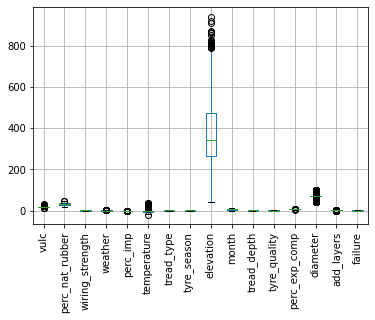

In [ ]:
df.boxplot(rot=90)
plt.show()

We observe that we will have some standardization to do. The elevation attribute has a very different scale from the other ones.

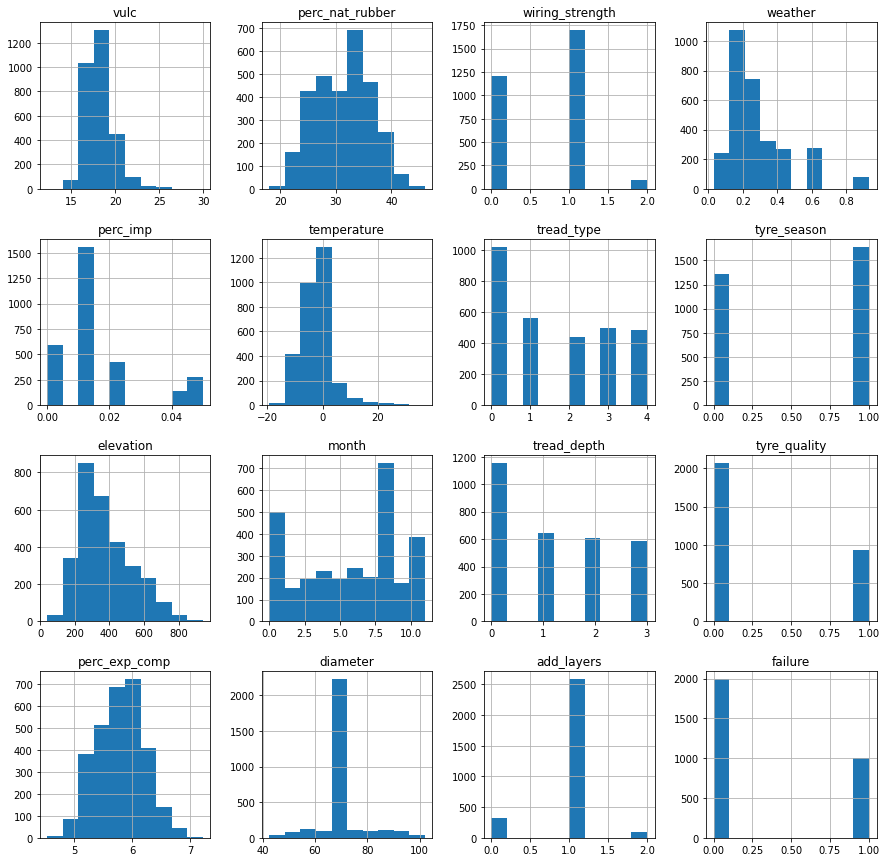

In [ ]:
df.hist(figsize=(15,15))
plt.show()

We notice that we have an imbalanced dataset. Indeed we have twice as many success-tests(2000) as we have failures(1000).

# 2. Data Preparation

As we noticed during the Exploratory Data Analysis, we need to apply some changes to our dataset before starting the classification

In [ ]:
df.dtypes # we know also from the pdf which of the attributes are numerical and which are not.

vulc               float64
perc_nat_rubber      int64
wiring_strength      int64
weather            float64
perc_imp           float64
temperature        float64
tread_type           int64
tyre_season          int64
elevation          float64
month                int64
tread_depth          int64
tyre_quality         int64
perc_exp_comp      float64
diameter           float64
add_layers           int64
failure              int64
dtype: object

In [ ]:
#We start by taking a look at the categorical attributes
df_categorical=df[["tread_type","month","tread_depth","wiring_strength","add_layers"]]
df_categorical.head()

,tread_type,month,tread_depth,wiring_strength,add_layers
0,0,8,0,1,1
1,2,11,1,1,1
2,0,0,1,1,1
3,1,7,3,1,1
4,0,2,2,2,1


Let's get some insight in what categorical variables might be informative for the classification task.

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


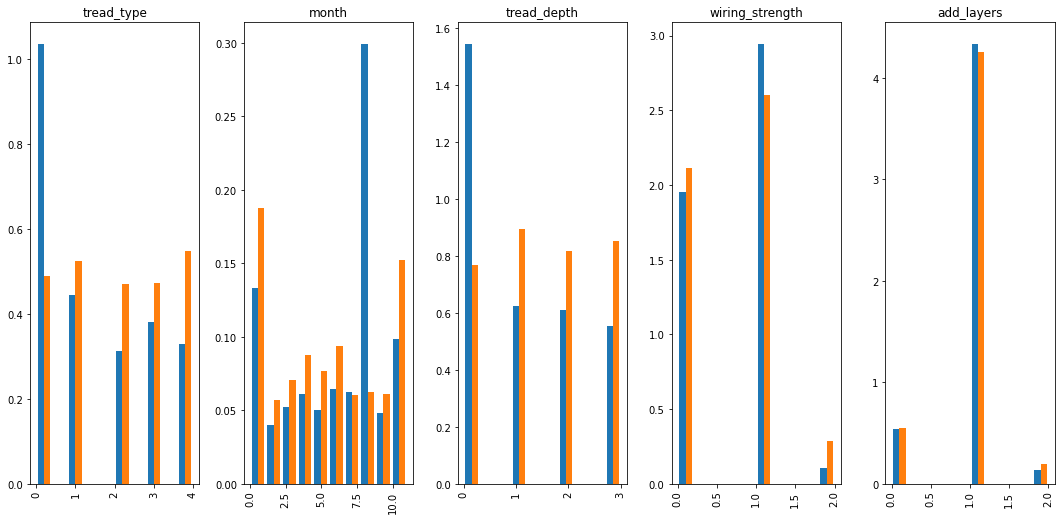

In [ ]:

df_0=df_categorical[df['failure']==0] # success
df_1=df_categorical[df['failure']==1] # failures

fig, axes = plt.subplots(1, 5,figsize=[15,7])
axes = axes.flatten()
fig.tight_layout(h_pad=10)

i=0
for x in df_categorical.columns:
    plt.sca(axes[i]) # set the current Axes
    plt.hist([df_0[x],df_1[x]],density=True)
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    plt.title(x)
    i+=1
plt.show()


In [ ]:
#Then, we focus on the binary attribute
df_binary = df[["tyre_season","tyre_quality"]] # We separate these from the categoricals bc we do not have to make dummies for them.(we would not want the dummies to have the opposite encoding)
df_binary.head()

,tyre_season,tyre_quality
0,1,1
1,0,0
2,0,0
3,0,1
4,1,0


In [ ]:
#Lastly, we look at the numerical attributes
df_numerical = df[["vulc","perc_nat_rubber","weather","perc_imp","temperature","elevation","perc_exp_comp","diameter"]]
df_numerical.head()

,vulc,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp,diameter
0,17.990,26,0.16,0.01,-8.12,332.5,5.13,55.000000
1,20.704,36,0.30,0.01,-4.52,328.0,6.15,72.085393
2,19.156,34,0.30,0.01,-1.08,247.0,6.36,72.085393
3,16.802,35,0.19,0.02,7.44,408.0,6.62,54.500000
4,17.140,23,0.39,0.01,30.52,308.0,6.15,76.300000


## 2.1 Standardization of the numerical attributes

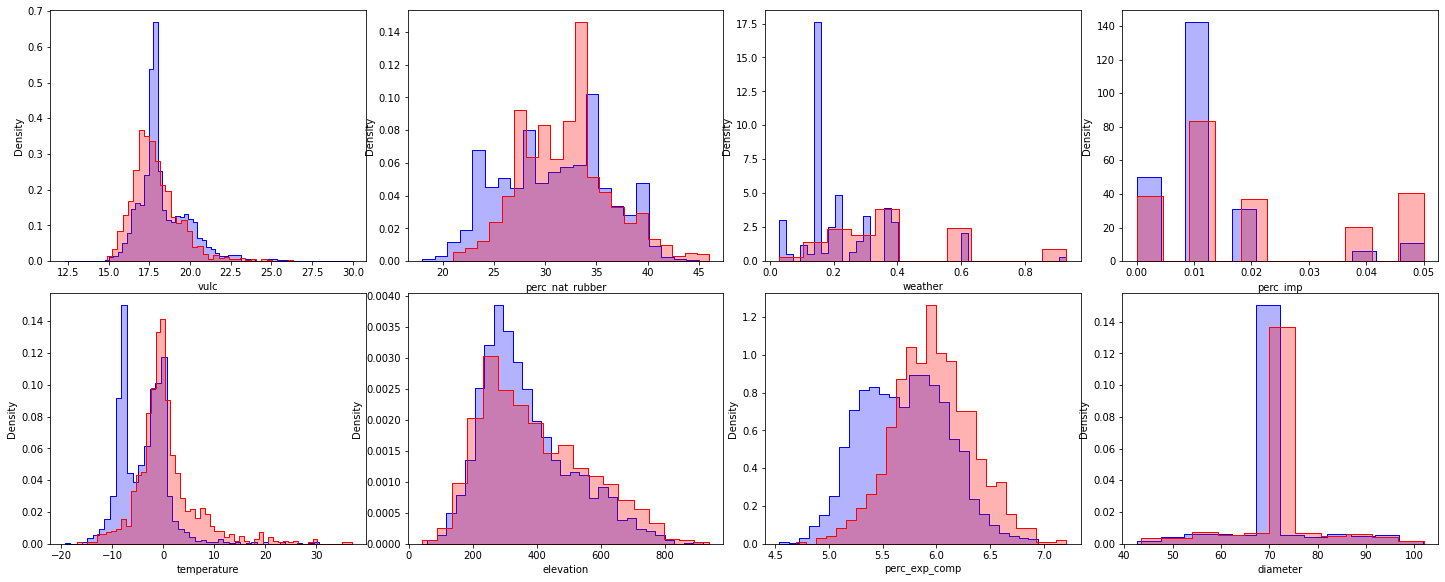

In [ ]:
# First inspect if we can retrieve some interesting insights from the data:

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

X0 = df_numerical[df['failure']==0]
X1 = df_numerical[df['failure']==1]

fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(20,8))
fig.tight_layout()

for i, ax in zip(range(df_numerical.columns.size), axes.flat):
    sns.histplot(X0.iloc[:,i], color="blue", ax=ax, stat='density', element="step",  alpha=0.3)
    sns.histplot(X1.iloc[:,i], color="red", ax=ax,stat='density', element="step",  alpha=0.3)
plt.show()

In [ ]:
# Scaling the dataset.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_numerical)
scaled_num_data = scaler.transform(df_numerical)

In [ ]:
#We print some interesting values(Mean,quantiles,standard deviation, min/max) for the numerical attribute
scaled_num_df = pd.DataFrame(scaled_num_data,columns=df_numerical.columns)
scaled_num_df.describe()

,vulc,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp,diameter
count,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03
mean,-6.690944e-16,7.638334e-17,6.276461e-17,-8.052818e-17,4.263256e-17,-1.717145e-16,7.152797e-16,1.764514e-16
std,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00
min,-3.700679e+00,-2.686209e+00,-1.380768e+00,-1.020379e+00,-2.980767e+00,-2.214622e+00,-3.050589e+00,-3.643467e+00
25%,-5.943634e-01,-6.588305e-01,-6.712449e-01,-3.190875e-01,-8.084019e-01,-7.456361e-01,-7.593140e-01,0.000000e+00
50%,-2.210006e-01,-5.061689e-02,-3.983515e-01,-3.190875e-01,5.208034e-02,-2.261974e-01,2.069460e-02,0.000000e+00
75%,4.721625e-01,7.603346e-01,4.749072e-01,3.822037e-01,4.329495e-01,6.315382e-01,7.032021e-01,0.000000e+00
max,7.402533e+00,2.990451e+00,3.531313e+00,2.486077e+00,6.942992e+00,3.727492e+00,3.457607e+00,3.684147e+00


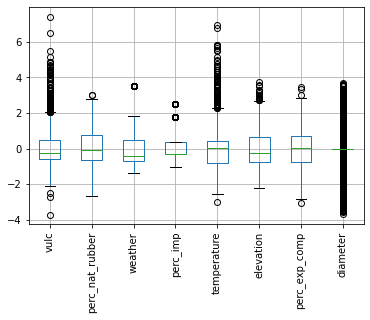

In [ ]:
scaled_num_df.boxplot(rot=90)

Since 2110 out of 3000 records were missing for the diameter feature, and we replace them by the mean value, we have 2110 records equal to the same value. Consequently, the first quertile, second quartile and third quartile are all equal to the same value (=0 after the standardization) and the values of the 890 records left are seen are "outliers"  when ploting the box plot

### 2.1.1 Numerical outlier detection 

In [ ]:
Q1 = scaled_num_df.quantile(0.25)
Q3 = scaled_num_df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

vulc               1.066526
perc_nat_rubber    1.419165
weather            1.146152
perc_imp           0.701291
temperature        1.241351
elevation          1.377174
perc_exp_comp      1.462516
diameter           0.000000
dtype: float64


In [ ]:
# print(scaled_num_df.shape)
# df_out = scaled_num_df[~((scaled_num_df < (Q1 - 3 * IQR)) |(scaled_num_df > (Q3 + 3 * IQR))).any(axis=1)]
# print(df_out.shape)

(3000, 8)
(2079, 8)


In [ ]:
# df_out.head()

,vulc,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp,diameter
1,1.587525,0.963073,0.092857,-0.319087,-0.378161,-0.318836,0.873829,0.0
2,0.612055,0.557597,0.092857,-0.319087,0.228409,-0.854817,1.385710,0.0
5,1.170367,1.368548,-1.326189,-0.319087,0.383578,-1.427193,0.410699,0.0
6,1.882434,0.354859,0.584065,-0.319087,0.016815,0.620785,1.653838,0.0
7,-0.931808,0.152121,1.839374,2.486077,-0.279417,-1.506597,-0.978691,0.0


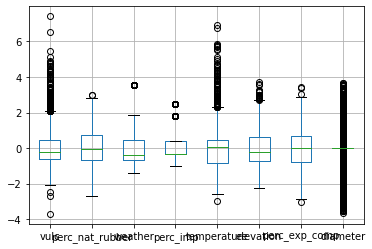

In [ ]:
scaled_num_df.boxplot()

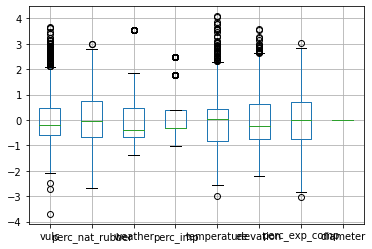

In [ ]:
# df_out.boxplot()

## 2.2 Converting categoricals into dummies

Here we will have to check if we can use the pd dummies or if we need to use the OneHotEncoder because it might be the case that not all the categoricals are present in the dataset. -> use onehotencoder just to be sure

In [ ]:
from sklearn.preprocessing import OneHotEncoder
dummies = pd.DataFrame()
print(df_categorical.columns)
for col in df_categorical.keys():
    encoder = OneHotEncoder(handle_unknown='ignore',drop='first') # leave out one column for every feature to avoid dummies
    encoder.fit(df_categorical[[col]])
    dummy = encoder.transform(df_categorical[[col]]).toarray()
    col_names = [col+str(j) for j in encoder.categories_[0][1:]] # We dropped the first category so we leave it also out when we generate the columnlabels
    D=pd.DataFrame(dummy,columns=col_names)
    dummies = pd.concat([dummies,D], axis = 1)
    

Index(['tread_type', 'month', 'tread_depth', 'wiring_strength', 'add_layers'], dtype='object')


## 2.3 Concatenating both numericals and dummies

In [ ]:
X=pd.concat([dummies,scaled_num_df,df_binary,df["failure"]], axis = 1)
X.dropna()
X.tail(5)

,tread_type1,tread_type2,tread_type3,tread_type4,month1,month2,month3,month4,month5,month6,...,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp,diameter,tyre_season,tyre_quality,failure
2995,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.456093,0.584065,-0.319087,1.702514,-0.586827,-0.271809,0.000000,1,1,1
2996,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.253355,-0.343773,-1.020379,0.164930,-1.480129,0.045070,0.000000,1,0,1
2997,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.354859,0.584065,-0.319087,-0.187726,-0.934222,-0.539937,0.000000,0,1,0
2998,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.165810,-1.380768,-1.020379,0.284834,-0.570284,0.240072,-1.456304,0,0,0
2999,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.354859,-1.217032,-1.020379,0.912563,0.190677,0.508200,-0.801391,0,0,0


In [ ]:
X[['month1','month2','month3','month4','month5','month6','month7','month8','month9','month10','month11']].sum(axis=1) #The encoding seems to work.

0       1.0
1       1.0
2       0.0
3       1.0
4       1.0
       ... 
2995    1.0
2996    1.0
2997    1.0
2998    1.0
2999    1.0
Length: 3000, dtype: float64

In [ ]:
X.shape

(3000, 33)

## 2.4 Balancing the dataset

As said previously, there are twice as much success as failure in the dataset. So, we want to balance it by oversampling to have similar numbers of success and failure

In [ ]:
from sklearn.utils import resample

df_majority = X[X.failure==0] 
df_minority = X[X.failure==1]
 
df_minority_oversampled = resample(df_minority, 
                                   replace=True,
                                   n_samples=2000,
                                   random_state=555) 
 
df_oversampled = pd.concat([df_minority_oversampled, df_majority])
df_oversampled.failure.value_counts()

1    2000
0    1992
Name: failure, dtype: int64

In [ ]:
data = df_oversampled
data.shape

(3992, 33)

We created 992 new records by oversampling, all of them being "failure". The new dataset is composed of 2000 records of success and 1992 of failure.

## 2.5 X and y sets seperation
We separe the datasets between X (all the attributes) and Y (the target variable) for the balanced dataset and the imbalanced one

In [ ]:
X = data.iloc[:,:-1] #seperation X & y sets on balanced dataset
y = data.iloc[:,-1]
X1 = X.iloc[:,:-1] ##seperation X & y sets on imbalanced dataset
y1 = X.iloc[:,-1]
#y.head()
y1.head()

1192    0
2055    0
2984    0
93      0
1710    0
Name: tyre_quality, dtype: int64

## 3 Define Train & Test sets 
The last step before the classification is to define a Train set and a Test set from our datasets.
For both dataset,the train set represents 70% of the records and the test set 30% of the records

In [ ]:
from sklearn.model_selection import train_test_split

#SPLIT DATA INTO TRAIN AND TEST SET on balanced dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size =0.30,
                                                    stratify=y,
                                                    random_state= 123
                                                   )
#SPLIT DATA INTO TRAIN AND TEST SET on imbalanced dataset
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, 
                                                    test_size =0.30,
                                                    stratify=y1,
                                                    random_state= 444
                                                   )

We now will apply several classifiers on both the balanced and imbalanced dataset to know which classifier produce the best resuts, and which dataset is the best one for the prediction of the target. We start with the KNN classifier

## 4.1 DEFINE KNN CLASSIFIER and PARAMETERS GRID by balanced data

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

classifier = KNeighborsClassifier()
parameters = {'n_neighbors':np.arange(10,50)}

gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=90, n_jobs=-1)
gs = gs.fit(X_train, y_train) #training the classifier

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_)) #summarize the results of GRIDSEARCH for different numbers of neighbors

means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean %f Std (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best score: 0.718655 using {'n_neighbors': 49}
Mean 0.694476 Std (0.011814) with: {'n_neighbors': 10}
Mean 0.708506 Std (0.006531) with: {'n_neighbors': 11}
Mean 0.689482 Std (0.009215) with: {'n_neighbors': 12}
Mean 0.709426 Std (0.007231) with: {'n_neighbors': 13}
Mean 0.695052 Std (0.005341) with: {'n_neighbors': 14}
Mean 0.712895 Std (0.006486) with: {'n_neighbors': 15}
Mean 0.703067 Std (0.006293) with: {'n_neighbors': 16}
Mean 0.712204 Std (0.005967) with: {'n_neighbors': 17}
Mean 0.698728 Std (0.008705) with: {'n_neighbors': 18}
Mean 0.704263 Std (0.005977) with: {'n_neighbors': 19}
Mean 0.697950 Std (0.004958) with: {'n_neighbors': 20}
Mean 0.712665 Std (0.003162) with: {'n_neighbors': 21}
Mean 0.705074 Std (0.002118) with: {'n_neighbors': 22}
Mean 0.709993 Std (0.005813) with: {'n_neighbors': 23}
Mean 0.703272 Std (0.006924) with: {'n_neighbors': 24}
Mean 0.704177 Std (0.005770) with: {'n_neighbors': 25}
Mean 0.6932

The best results are obtained for 49 neighbors

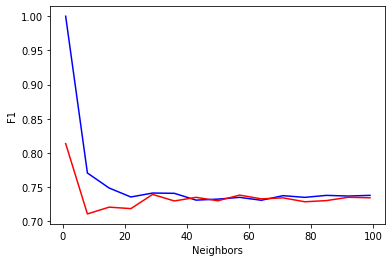

In [ ]:
#We plot the F1-score in function of the number of neighbors for the test set (in red) and the train set (in blue)
from sklearn import metrics
score_train=[]
score_test=[]

neighbors=range(1,100,7)

for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    y_pred_train = knn.predict(X_train)
    y_pred_test = knn.predict(X_test)
    score_train.append( metrics.f1_score(y_train, y_pred_train))
    score_test.append( metrics.f1_score(y_test, y_pred_test))

plt.xlabel('Neighbors')
plt.ylabel('F1')
plt.plot (neighbors,score_train, color='blue', alpha=1.00)
plt.plot (neighbors,score_test, color='red', alpha=1.00)

plt.show()

              precision    recall  f1-score   support

           0       0.75      0.67      0.71       598
           1       0.70      0.78      0.74       600

    accuracy                           0.73      1198
   macro avg       0.73      0.73      0.72      1198
weighted avg       0.73      0.73      0.72      1198



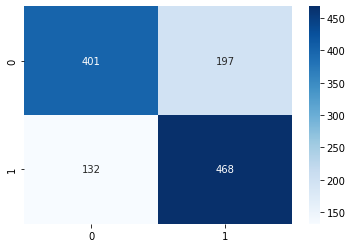

In [ ]:
# test on the test set
best_model = gs.best_estimator_ #We chose as a model the KNN-classifier with the number of neighbor providing the best score

y_pred_train = best_model.predict(X_train)
y_pred = best_model.predict(X_test)

# Prediction on the test set evaluation

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues");

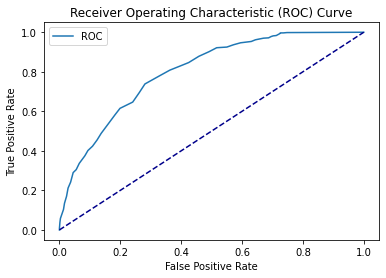

AUC: 0.80


In [ ]:
model = best_model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

y_probs = model.predict_proba(X_test)

fpr, tpr, thresholds=metrics.roc_curve(y_test,  y_probs[:,1])

plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print('AUC: %.2f' % auc)

## 4.2 DEFINE KNN CLASSIFIER and PARAMETERS GRID by imbalanced data
We repeat the same steps for the imbalanced dataset

In [ ]:
classifier = KNeighborsClassifier()
parameters = {'n_neighbors':np.arange(10,50)}

gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=90, n_jobs=-1)
gs = gs.fit(X1_train, y1_train) #training the classifier

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_)) #summarize the results of GRIDSEARCH

means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean %f Std (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best score: 0.842564 using {'n_neighbors': 10}
Mean 0.842564 Std (0.007110) with: {'n_neighbors': 10}
Mean 0.840667 Std (0.004798) with: {'n_neighbors': 11}
Mean 0.832159 Std (0.006072) with: {'n_neighbors': 12}
Mean 0.832335 Std (0.003167) with: {'n_neighbors': 13}
Mean 0.830445 Std (0.007972) with: {'n_neighbors': 14}
Mean 0.832536 Std (0.008158) with: {'n_neighbors': 15}
Mean 0.831637 Std (0.007461) with: {'n_neighbors': 16}
Mean 0.833934 Std (0.004287) with: {'n_neighbors': 17}
Mean 0.833329 Std (0.002973) with: {'n_neighbors': 18}
Mean 0.832171 Std (0.003300) with: {'n_neighbors': 19}
Mean 0.833054 Std (0.005081) with: {'n_neighbors': 20}
Mean 0.833033 Std (0.005301) with: {'n_neighbors': 21}
Mean 0.834442 Std (0.008226) with: {'n_neighbors': 22}
Mean 0.832413 Std (0.009747) with: {'n_neighbors': 23}
Mean 0.830397 Std (0.007513) with: {'n_neighbors': 24}
Mean 0.831666 Std (0.007680) with: {'n_neighbors': 25}
Mean 0.8315

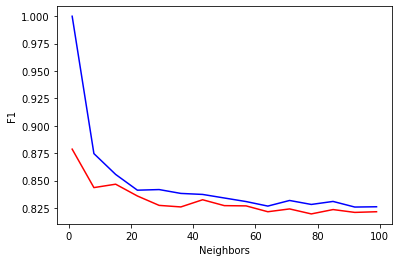

In [ ]:
#We plot the F1-score in function of the number of neighbors for the test set (in red) and the train set (in blue)
from sklearn import metrics
score_train=[]
score_test=[]

neighbors=range(1,100,7)

for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X1_train,y1_train)
    y1_pred_train = knn.predict(X1_train)
    y1_pred_test = knn.predict(X1_test)
    score_train.append( metrics.f1_score(y1_train, y1_pred_train))
    score_test.append( metrics.f1_score(y1_test, y1_pred_test))

plt.xlabel('Neighbors')
plt.ylabel('F1')
plt.plot (neighbors,score_train, color='blue', alpha=1.00)
plt.plot (neighbors,score_test, color='red', alpha=1.00)

plt.show()

The best results are obtained for 10 neighbors

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       892
           1       0.92      0.79      0.85       306

    accuracy                           0.93      1198
   macro avg       0.92      0.88      0.90      1198
weighted avg       0.93      0.93      0.93      1198



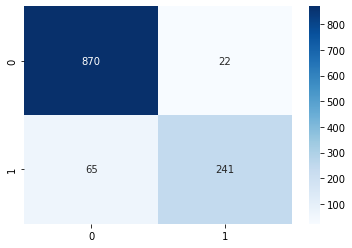

In [ ]:
# test on the test set
best_model = gs.best_estimator_

y1_pred_train = best_model.predict(X1_train)
y1_pred = best_model.predict(X1_test)

# Prediction on the test set evaluation
print(classification_report(y1_test, y1_pred))

sns.heatmap(confusion_matrix(y1_test, y1_pred), annot=True, fmt='d', cmap="Blues");

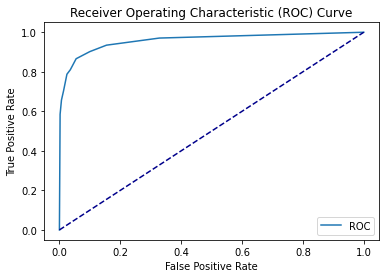

AUC: 0.96


In [ ]:
model = best_model
model.fit(X1_train, y1_train)
y1_pred = model.predict(X1_test)

y1_probs = model.predict_proba(X1_test)

fpr, tpr, thresholds=metrics.roc_curve(y1_test,  y1_probs[:,1])

plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y1_test, y1_probs[:,1])
print('AUC: %.2f' % auc)

We notice that both the f1 score and AUC are higher with the imbalanced dataset than with the balanced one 

# 4.3 Classification tree for balanced data

---



The second classification model we try on our dataset is the classification tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=2, min_samples_leaf=2)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Definition of the classifier and the parameters grid

classifier = DecisionTreeClassifier()
parameters = {'criterion': ['entropy','gini'],
              'max_depth': [3,5,10,50],
              'min_samples_split': [5,10],
              'min_samples_leaf': [2,4]}

#Definition of the gridsearch 

gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=10, n_jobs=-1)
#Training
gs = gs.fit(X_train, y_train)
#Summary of the results
print('***GRIDSEARCH RESULTS FOR BALANCED DATA***')

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 32 candidates, totalling 96 fits
***GRIDSEARCH RESULTS FOR BALANCED DATA***
Best score: 0.766967 using {'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.735952 (0.018943) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.735952 (0.018943) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10}
0.735952 (0.018943) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 5}
0.735952 (0.018943) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10}
0.749521 (0.016730) with: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.749096 (0.017327) with: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
0.749456 (0.017080) with: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'mi

The best f1_score is obtained when the criterion used is 'entropy', with  max_depth=50, min_samples_leaf=2 and min_samples_split=5

              precision    recall  f1-score   support

           0       0.79      0.75      0.77       598
           1       0.76      0.81      0.78       600

    accuracy                           0.78      1198
   macro avg       0.78      0.78      0.78      1198
weighted avg       0.78      0.78      0.78      1198



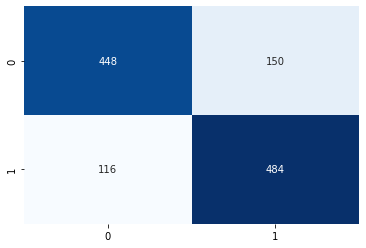

In [ ]:
#Testing of the model set
best_model = gs.best_estimator_ #we keep the gridsearch that gives the best results
y_pred = best_model.predict(X_test)

y_pred_train = best_model.predict(X_train)

#Classfication report for y_test
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues", cbar=False);

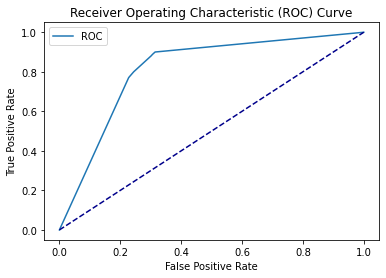

AUC: 0.81


In [ ]:
#Plot the ROC-curve

model = best_model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test) 

fpr, tpr, thresholds=metrics.roc_curve(y_test,  y_probs[:,1])


plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print('AUC: %.2f' % auc)

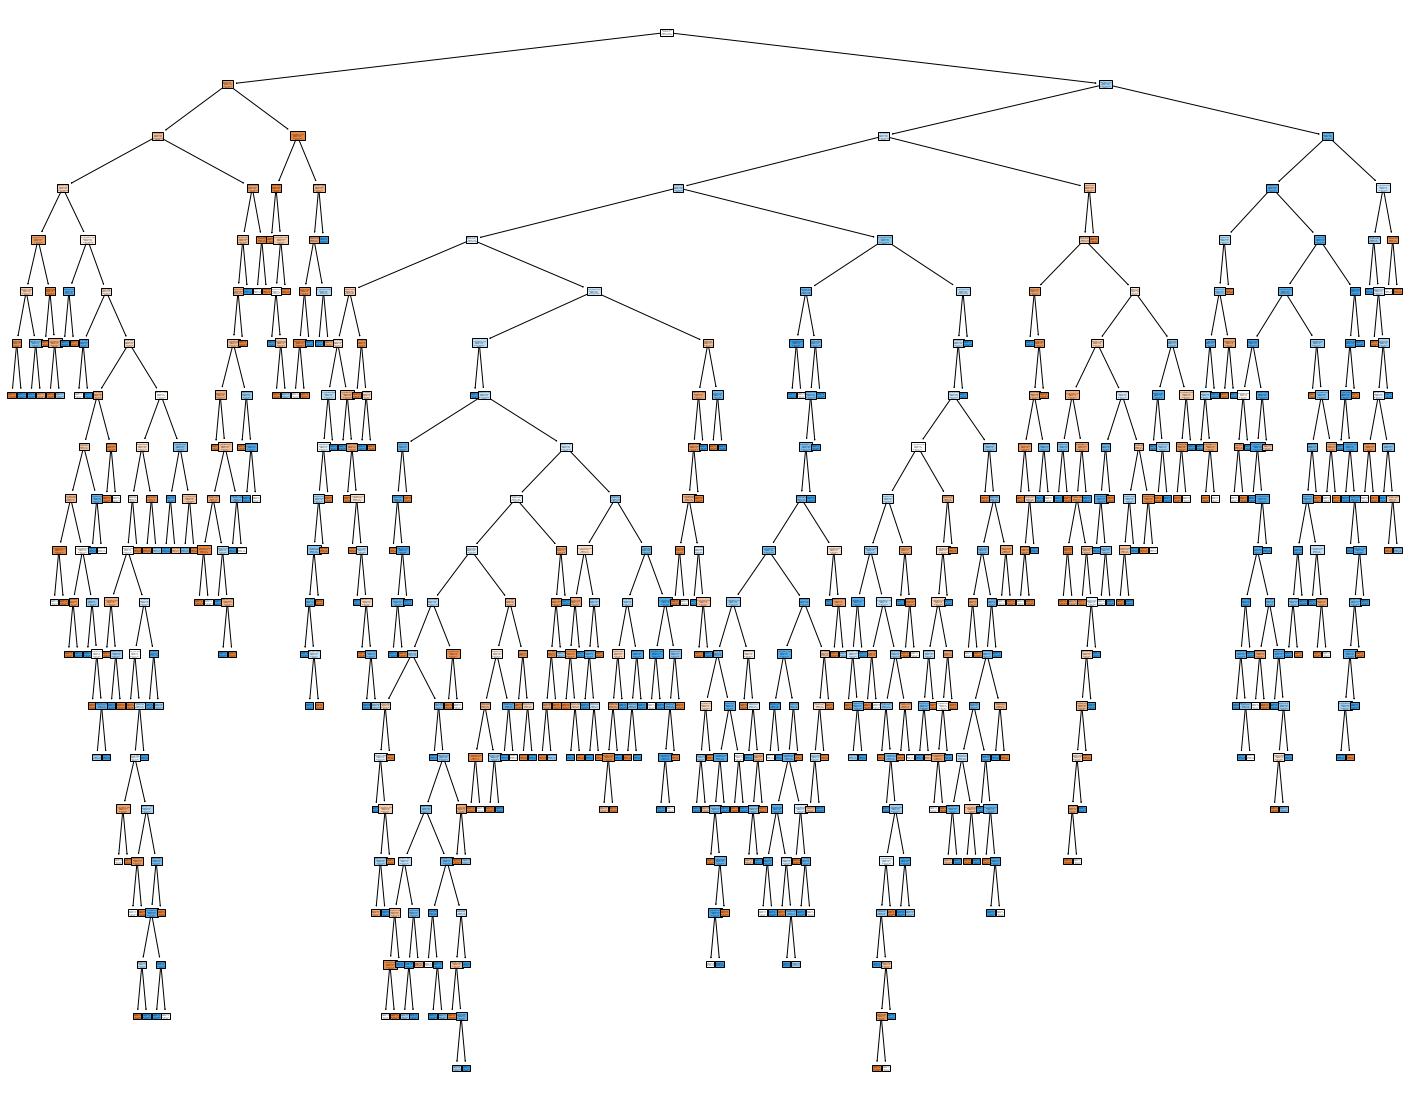

In [ ]:
#Plot the classification tree
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_model, 
                   feature_names=X_test.columns.tolist(),  
                   class_names=['0','1'],
                   filled=True)

<AxesSubplot:>

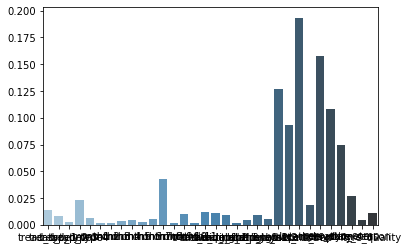

In [ ]:
#We want to see the barplot to know which attributes are the most important for the classification
sns.barplot(x=X_train.columns[best_model.feature_importances_ >0], y=best_model.feature_importances_[best_model.feature_importances_ >0], palette="Blues_d")

# 4.4 Classification tree for imbalanced data

In [ ]:
#We repeat the same steps as with the classification tree for balanced data
model = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=2, min_samples_leaf=2)

model.fit(X1_train, y1_train)
y1_pred = model.predict(X1_test) 
#Definition of the classifier and the parameters grid
classifier = DecisionTreeClassifier()
parameters = {'criterion': ['entropy','gini'],
              'max_depth': [3,5,10, 50],
              'min_samples_split': [5,10],
              'min_samples_leaf': [2,4]}
#Definition of the griedsearch

gs1 = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=10, n_jobs=-1)
#Training
gs1 = gs1.fit(X1_train, y1_train)
#summary of the results
print('***GRIDSEARCH RESULTS FOR UNBALANCED DATA***')

print("Best score: %f using %s" % (gs1.best_score_, gs1.best_params_))
means = gs1.cv_results_['mean_test_score']
stds = gs1.cv_results_['std_test_score']
params = gs1.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 32 candidates, totalling 96 fits
***GRIDSEARCH RESULTS FOR UNBALANCED DATA***
Best score: 0.913372 using {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.893575 (0.010424) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.892973 (0.009706) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10}
0.893575 (0.010424) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 5}
0.892973 (0.009706) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10}
0.913372 (0.011614) with: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.908091 (0.012334) with: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
0.907388 (0.010383) with: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'm

The best f1_score is obtained when the criterion used is 'gini', with max_depth=5, min_samples_leaf=2 and min_samples_split=5

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       892
           1       0.96      0.91      0.93       306

    accuracy                           0.96      1198
   macro avg       0.96      0.95      0.95      1198
weighted avg       0.96      0.96      0.96      1198



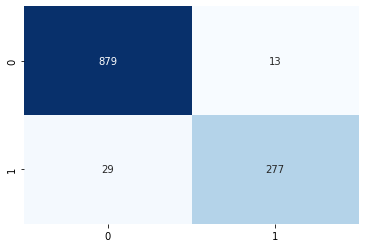

In [ ]:
#Testing
best_model = gs1.best_estimator_
y1_pred = best_model.predict(X1_test)

y1_pred_train = best_model.predict(X1_train)

#Classfication report for y1_test
print(classification_report(y1_test, y1_pred))

# Plot confusion matrix
sns.heatmap(confusion_matrix(y1_test, y1_pred), annot=True, fmt='d', cmap="Blues", cbar=False);

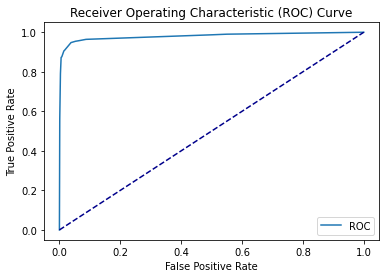

AUC: 0.98


In [ ]:
#Plot of the ROC_curve
model = best_model
model.fit(X1_train, y1_train)

y1_pred = model.predict(X1_test)
y1_probs = model.predict_proba(X1_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

fpr, tpr, thresholds=metrics.roc_curve(y1_test,  y1_probs[:,1])


plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y1_test, y1_probs[:,1])
print('AUC: %.2f' % auc)

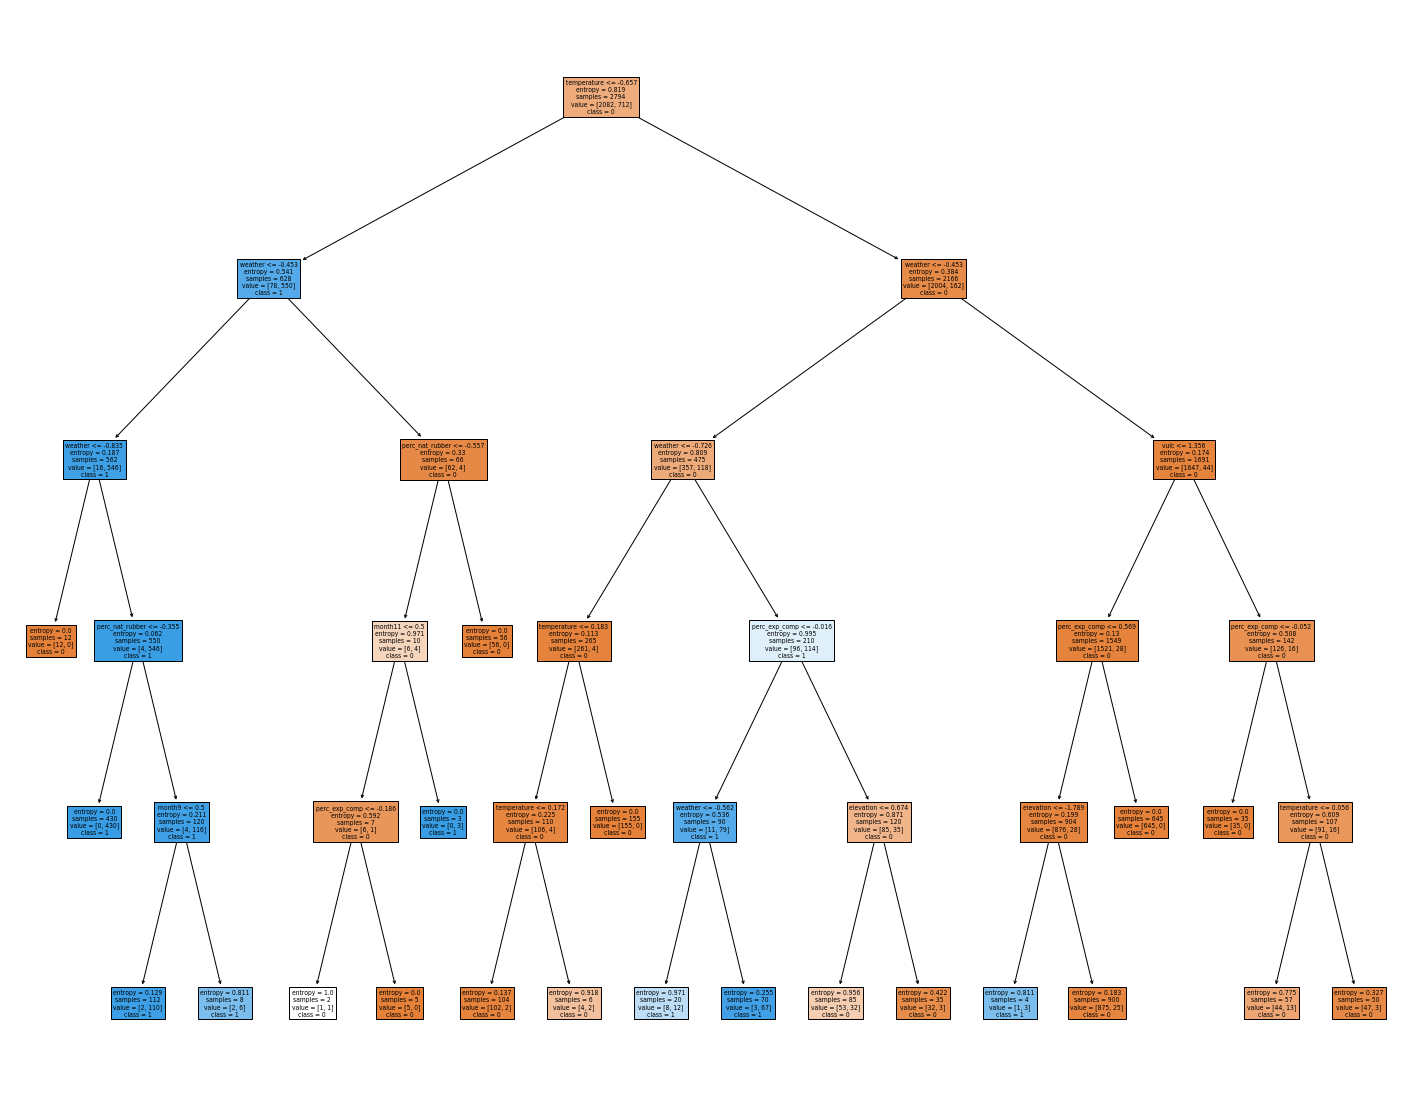

In [ ]:
#Ploting of the classification tree for the unbalanced data
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_model, 
                   feature_names=X1_test.columns.tolist(),  
                   class_names=['0','1'],
                   filled=True)

<AxesSubplot:>

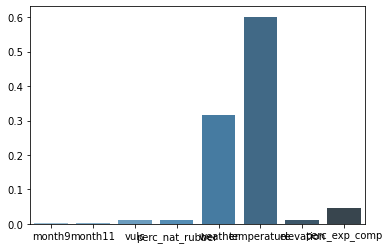

In [ ]:
#We want to see the barplot to know which attributes are the most important for the classification
sns.barplot(x=X1_train.columns[best_model.feature_importances_ >0], y=best_model.feature_importances_[best_model.feature_importances_ >0], palette="Blues_d")

# 4.5 Naive bayes classification for balanced dataset

The next one is the Naive Bayes Classification

In [ ]:
from sklearn.naive_bayes import GaussianNB 

model = GaussianNB()

model.fit(X_train, y_train)
y_pred=model.predict(X_test)

y_pred_train=model.predict(X_train)
#Classfication report for y_test
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.59      0.64       598
           1       0.65      0.74      0.69       600

    accuracy                           0.67      1198
   macro avg       0.67      0.67      0.67      1198
weighted avg       0.67      0.67      0.67      1198



# 4.6 Naive Bayes classification for imbalanced dataset
Even though the Naive Bayes is not the best choice for the balanced data, we still try it on the imbalanced data

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       892
           1       0.96      0.91      0.93       306

    accuracy                           0.96      1198
   macro avg       0.96      0.95      0.95      1198
weighted avg       0.96      0.96      0.96      1198



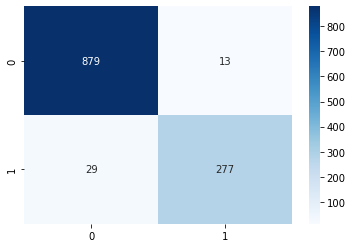

In [ ]:
model = GaussianNB()

model.fit(X1_train, y1_train)
y_pred=model.predict(X1_test)

y_pred_train=model.predict(X1_train)
#Printing of the classification report for y1_test
print(classification_report(y1_test, y1_pred))

sns.heatmap(confusion_matrix(y1_test, y1_pred), annot=True, fmt='d', cmap="Blues");

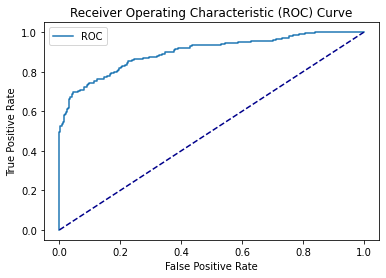

AUC: 0.90


In [ ]:
#ROC curve for the imbalanced data
y1_probs = model.predict_proba(X1_test) 
fpr, tpr, thresholds=metrics.roc_curve(y1_test,  y1_probs[:,1])

plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y1_test, y1_probs[:,1])
print('AUC: %.2f' % auc)


# 4.7 Perceptron Classifier (NN) on balanced dataset

Now, we try to use the Perceptron classifier on our datasets

In [ ]:
# Constructing the MLP
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier()
parameters = {"hidden_layer_sizes":[(a, b, c) for a in range(2,5) for b in range(2,5) for c in range(2,5)],  "max_iter": [500000], "alpha": [0.001,0.01,0.1],"solver":["lbfgs"]}

# Optimization of the hyperparameters
gs_MLP = GridSearchCV(classifier, parameters, cv=5, scoring = 'f1', verbose=50, n_jobs=-1, refit=True)
gs_MLP = gs_MLP.fit(X_train, y_train)

#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs_MLP.best_score_, gs_MLP.best_params_))
means = gs_MLP.cv_results_['mean_test_score']
stds = gs_MLP.cv_results_['std_test_score']
params = gs_MLP.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
***GRIDSEARCH RESULTS***
Best score: 0.759691 using {'alpha': 0.01, 'hidden_layer_sizes': (4, 3, 4), 'max_iter': 500000, 'solver': 'lbfgs'}
0.741227 (0.006981) with: {'alpha': 0.001, 'hidden_layer_sizes': (2, 2, 2), 'max_iter': 500000, 'solver': 'lbfgs'}
0.727496 (0.032418) with: {'alpha': 0.001, 'hidden_layer_sizes': (2, 2, 3), 'max_iter': 500000, 'solver': 'lbfgs'}
0.746432 (0.014890) with: {'alpha': 0.001, 'hidden_layer_sizes': (2, 2, 4), 'max_iter': 500000, 'solver': 'lbfgs'}
0.733838 (0.003923) with: {'alpha': 0.001, 'hidden_layer_sizes': (2, 3, 2), 'max_iter': 500000, 'solver': 'lbfgs'}
0.742837 (0.017616) with: {'alpha': 0.001, 'hidden_layer_sizes': (2, 3, 3), 'max_iter': 500000, 'solver': 'lbfgs'}
0.740553 (0.023780) with: {'alpha': 0.001, 'hidden_layer_sizes': (2, 3, 4), 'max_iter': 500000, 'solver': 'lbfgs'}
0.734739 (0.015336) with: {'alpha': 0.001, 'hidden_layer_sizes': (2, 4, 2), 'max_iter': 500000, 'solver': 'l

              precision    recall  f1-score   support

           0       0.83      0.64      0.72       598
           1       0.71      0.87      0.78       600

    accuracy                           0.75      1198
   macro avg       0.77      0.75      0.75      1198
weighted avg       0.77      0.75      0.75      1198



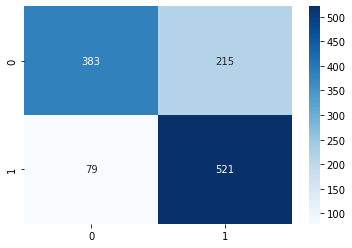

In [ ]:
#Testing the model
best_model = gs_MLP.best_estimator_
y_pred = best_model.predict(X_test)

y_pred_train = best_model.predict(X_train)

#EVALUATION OF THE PREDICTION
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues"); #annot=True to annotate cells fmt: format

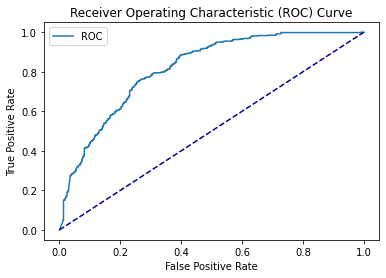

AUC: 0.82


In [ ]:
#ROC curve for the balanced data

model=best_model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

y_probs = model.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

fpr, tpr, thresholds=metrics.roc_curve(y_test,  y_probs[:,1])


plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print('AUC: %.2f' % auc)

# 4.8 Perceptron Classifier (NN) on imbalanced dataset

In [ ]:
# Constructing the MLP
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier()
parameters = {"hidden_layer_sizes":[(a, b, c) for a in range(2,5) for b in range(2,5) for c in range(2,5)],  "max_iter": [500000], "alpha": [0.001,0.01,0.1],"solver":["lbfgs"]}

# Optimization of the hyperparameters
gs_MLP = GridSearchCV(classifier, parameters, cv=5, scoring = 'f1', verbose=50, n_jobs=-1, refit=True)
gs_MLP = gs_MLP.fit(X1_train, y1_train)

#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs_MLP.best_score_, gs_MLP.best_params_))
means = gs_MLP.cv_results_['mean_test_score']
stds = gs_MLP.cv_results_['std_test_score']
params = gs_MLP.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
***GRIDSEARCH RESULTS***
Best score: 0.914079 using {'alpha': 0.01, 'hidden_layer_sizes': (3, 2, 2), 'max_iter': 500000, 'solver': 'lbfgs'}
0.497060 (0.408169) with: {'alpha': 0.001, 'hidden_layer_sizes': (2, 2, 2), 'max_iter': 500000, 'solver': 'lbfgs'}
0.530947 (0.434044) with: {'alpha': 0.001, 'hidden_layer_sizes': (2, 2, 3), 'max_iter': 500000, 'solver': 'lbfgs'}
0.705892 (0.353046) with: {'alpha': 0.001, 'hidden_layer_sizes': (2, 2, 4), 'max_iter': 500000, 'solver': 'lbfgs'}
0.701633 (0.350971) with: {'alpha': 0.001, 'hidden_layer_sizes': (2, 3, 2), 'max_iter': 500000, 'solver': 'lbfgs'}
0.705742 (0.353508) with: {'alpha': 0.001, 'hidden_layer_sizes': (2, 3, 3), 'max_iter': 500000, 'solver': 'lbfgs'}
0.712620 (0.356396) with: {'alpha': 0.001, 'hidden_layer_sizes': (2, 3, 4), 'max_iter': 500000, 'solver': 'lbfgs'}
0.898209 (0.018235) with: {'alpha': 0.001, 'hidden_layer_sizes': (2, 4, 2), 'max_iter': 500000, 'solver': 'l

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       892
           1       0.92      0.85      0.88       306

    accuracy                           0.94      1198
   macro avg       0.93      0.91      0.92      1198
weighted avg       0.94      0.94      0.94      1198



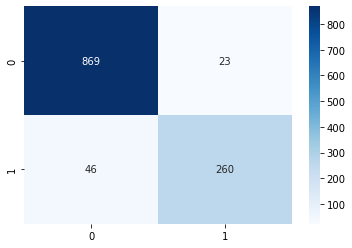

In [ ]:
#Testing the model
best_model = gs_MLP.best_estimator_
y_pred = best_model.predict(X1_test)

y_pred_train = best_model.predict(X1_train)

#EVALUATION OF THE PREDICTION
print(classification_report(y1_test, y_pred))

sns.heatmap(confusion_matrix(y1_test, y_pred), annot=True, fmt='d', cmap="Blues"); #annot=True to annotate cells fmt: format

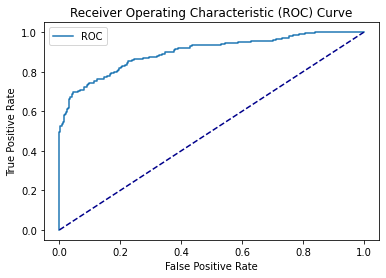

AUC: 0.90


In [ ]:
#ROC curve for the imbalanced data
model=best_model
model.fit(X1_train, y1_train)

y_pred = model.predict(X1_test)
y_pred_train = model.predict(X1_train)

y_probs = model.predict_proba(X1_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

fpr, tpr, thresholds=metrics.roc_curve(y1_test,  y1_probs[:,1])


plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y1_test, y1_probs[:,1])
print('AUC: %.2f' % auc)

# 4.9 SVM for balanced data
The next classifier we use on our datasets is the SVM

In [ ]:
from sklearn.svm import SVC

model = SVC(kernel='sigmoid',C=1)

model.fit(X_train, y_train)
model.predict(X_test)
from sklearn.svm import SVC

#DEFINE CLASSIFIER and THE PARAMETERS GRID
classifier = SVC()
parameters = {"kernel":['linear','rbf','polynomial'], "C":[0.1,1,100],"gamma":[1], "degree":[2,3,4]}

#DEFINE GRIDSEARCH 
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=50, n_jobs=-1, refit=True)

#TRAIN CLASSIFIER
gs = gs.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
27 fits failed out of a total of 81.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 315, in _dense_fit
    ) = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", lin

One of the fold failed, which might distort the quality of the results for this classifier

In [ ]:
#summarize the results of GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

***GRIDSEARCH RESULTS***
Best score: 0.769138 using {'C': 100, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}
0.740446 (0.015130) with: {'C': 0.1, 'degree': 2, 'gamma': 1, 'kernel': 'linear'}
0.719611 (0.000814) with: {'C': 0.1, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}
nan (nan) with: {'C': 0.1, 'degree': 2, 'gamma': 1, 'kernel': 'polinomial'}
0.740446 (0.015130) with: {'C': 0.1, 'degree': 3, 'gamma': 1, 'kernel': 'linear'}
0.719611 (0.000814) with: {'C': 0.1, 'degree': 3, 'gamma': 1, 'kernel': 'rbf'}
nan (nan) with: {'C': 0.1, 'degree': 3, 'gamma': 1, 'kernel': 'polinomial'}
0.740446 (0.015130) with: {'C': 0.1, 'degree': 4, 'gamma': 1, 'kernel': 'linear'}
0.719611 (0.000814) with: {'C': 0.1, 'degree': 4, 'gamma': 1, 'kernel': 'rbf'}
nan (nan) with: {'C': 0.1, 'degree': 4, 'gamma': 1, 'kernel': 'polinomial'}
0.740085 (0.012069) with: {'C': 1, 'degree': 2, 'gamma': 1, 'kernel': 'linear'}
0.762210 (0.009030) with: {'C': 1, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}
nan (nan) with: {'C': 1, 'd

              precision    recall  f1-score   support

           0       0.78      0.97      0.87       598
           1       0.97      0.73      0.83       600

    accuracy                           0.85      1198
   macro avg       0.88      0.85      0.85      1198
weighted avg       0.88      0.85      0.85      1198



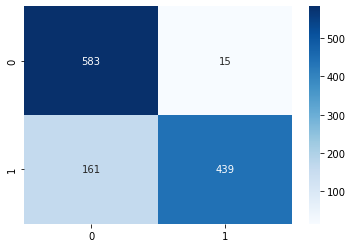

In [ ]:
#TEST ON TEST SET 
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)

y_pred_train = best_model.predict(X_train)

#PRINT SOME FURTHER METRICS
print(classification_report(y_test, y_pred))

#CONFUSION MATRIX
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues");

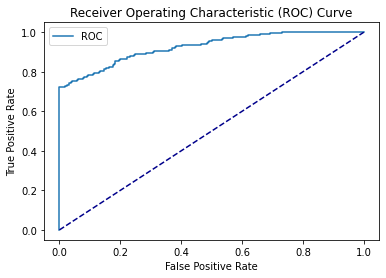

AUC: 0.93


In [ ]:

from sklearn import metrics

model = SVC(C=100,degree=2, gamma=1, kernel='rbf',probability=True)


model.fit(X_train, y_train)
y_pred = model.predict(X_test)

y_probs = model.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

fpr, tpr, thresholds=metrics.roc_curve(y_test,  y_probs[:,1])

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print('AUC: %.2f' % auc)

# 3.10 SVM for imbalanced data

In [ ]:
model = SVC(kernel='sigmoid',C=1)

model.fit(X1_train, y1_train)
model.predict(X1_test)

#DEFINE CLASSIFIER and THE PARAMETERS GRID
classifier = SVC()
parameters = {"kernel":['linear','rbf','polinomial'], "C":[0.1,1,100],"gamma":[1], "degree":[2,3,4]}

#DEFINE GRIDSEARCH 
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=50, n_jobs=-1, refit=True)

#TRAIN CLASSIFIER
gs = gs.fit(X1_train, y1_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
27 fits failed out of a total of 81.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 315, in _dense_fit
    ) = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", lin

One of the fold failed, which might distorts the quality of the resukts for this classifier

In [ ]:
#summarize the results of GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

***GRIDSEARCH RESULTS***
Best score: 0.866264 using {'C': 1, 'degree': 2, 'gamma': 1, 'kernel': 'linear'}
0.862147 (0.006382) with: {'C': 0.1, 'degree': 2, 'gamma': 1, 'kernel': 'linear'}
0.604818 (0.026287) with: {'C': 0.1, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}
nan (nan) with: {'C': 0.1, 'degree': 2, 'gamma': 1, 'kernel': 'polinomial'}
0.862147 (0.006382) with: {'C': 0.1, 'degree': 3, 'gamma': 1, 'kernel': 'linear'}
0.604818 (0.026287) with: {'C': 0.1, 'degree': 3, 'gamma': 1, 'kernel': 'rbf'}
nan (nan) with: {'C': 0.1, 'degree': 3, 'gamma': 1, 'kernel': 'polinomial'}
0.862147 (0.006382) with: {'C': 0.1, 'degree': 4, 'gamma': 1, 'kernel': 'linear'}
0.604818 (0.026287) with: {'C': 0.1, 'degree': 4, 'gamma': 1, 'kernel': 'rbf'}
nan (nan) with: {'C': 0.1, 'degree': 4, 'gamma': 1, 'kernel': 'polinomial'}
0.866264 (0.009977) with: {'C': 1, 'degree': 2, 'gamma': 1, 'kernel': 'linear'}
0.760376 (0.019458) with: {'C': 1, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}
nan (nan) with: {'C': 1, '

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       892
           1       0.90      0.87      0.88       306

    accuracy                           0.94      1198
   macro avg       0.93      0.92      0.92      1198
weighted avg       0.94      0.94      0.94      1198



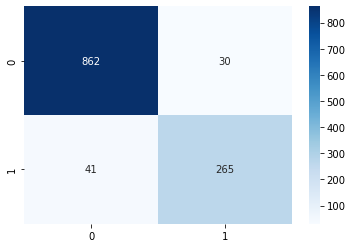

In [ ]:
#TEST ON TEST SET 
best_model = gs.best_estimator_
y1_pred = best_model.predict(X1_test)

y1_pred_train = best_model.predict(X1_train)

#PRINT SOME FURTHER METRICS

print(classification_report(y1_test, y1_pred))

#CONFUSION MATRIX
sns.heatmap(confusion_matrix(y1_test, y1_pred), annot=True, fmt='d', cmap="Blues");

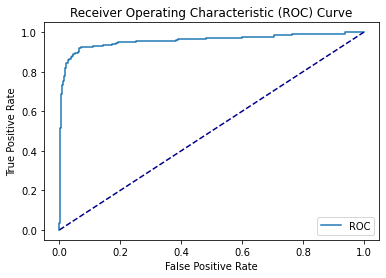

AUC: 0.96


In [ ]:
model = SVC(C=1,degree=2, gamma=1, kernel='linear',probability=True)

model.fit(X1_train, y1_train)
y1_pred = model.predict(X1_test)

y1_probs = model.predict_proba(X1_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

fpr, tpr, thresholds=metrics.roc_curve(y1_test,  y1_probs[:,1])


plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y1_test, y1_probs[:,1])
print('AUC: %.2f' % auc)

# 3.11 Adaboost on balanced data

We now try some ensemble classifier on the datasets, starting with Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
adaboost = AdaBoostClassifier(n_estimators=1000, base_estimator=DecisionTreeClassifier(max_depth=3))
adaboost.fit(X_train, y_train)

y_pred = adaboost.predict(X_test)

y_pred_train = adaboost.predict(X_test)
print("f1_score: ", metrics.f1_score(y_test, y_pred))

f1_score:  0.8406026962727994


In [ ]:
from sklearn.model_selection import GridSearchCV

classifier= AdaBoostClassifier()
parameters = {'n_estimators' : [2000, 5000],
    'learning_rate' : [0.0001, 0.01, 0.1, 1, 10]}

gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=10, n_jobs=-1, refit=True)

gs.fit(X_train,y_train)
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
***GRIDSEARCH RESULTS***
Best score: 0.774896 using {'learning_rate': 1, 'n_estimators': 5000}
0.737769 (0.008321) with: {'learning_rate': 0.0001, 'n_estimators': 2000}
0.735386 (0.008220) with: {'learning_rate': 0.0001, 'n_estimators': 5000}
0.743230 (0.008711) with: {'learning_rate': 0.01, 'n_estimators': 2000}
0.752705 (0.007398) with: {'learning_rate': 0.01, 'n_estimators': 5000}
0.744588 (0.008948) with: {'learning_rate': 0.1, 'n_estimators': 2000}
0.748593 (0.008357) with: {'learning_rate': 0.1, 'n_estimators': 5000}
0.758072 (0.007673) with: {'learning_rate': 1, 'n_estimators': 2000}
0.774896 (0.010172) with: {'learning_rate': 1, 'n_estimators': 5000}
0.133840 (0.095520) with: {'learning_rate': 10, 'n_estimators': 2000}
0.133840 (0.095520) with: {'learning_rate': 10, 'n_estimators': 5000}


              precision    recall  f1-score   support

           0       0.81      0.76      0.78       598
           1       0.77      0.82      0.79       600

    accuracy                           0.79      1198
   macro avg       0.79      0.79      0.79      1198
weighted avg       0.79      0.79      0.79      1198



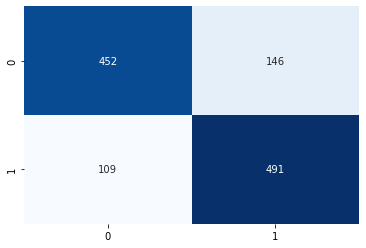

In [ ]:
from sklearn.metrics import classification_report

best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues", cbar=False);

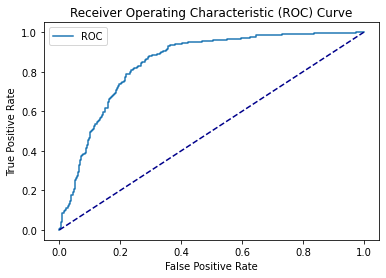

AUC: 0.85


In [ ]:
adaboost = best_model

adaboost.fit(X_train,y_train)

y_probs = adaboost.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

fpr, tpr, thresholds=metrics.roc_curve(y_test,  y_probs[:,1])

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print('AUC: %.2f' % auc)

# 3.12 Adaboost on imbalanced data

In [ ]:
adaboost = AdaBoostClassifier(n_estimators=1000, base_estimator=DecisionTreeClassifier(max_depth=3))
adaboost.fit(X1_train, y1_train)

y1_pred = adaboost.predict(X1_test)

y1_pred_train = adaboost.predict(X1_test)
print("f1_score: ", metrics.f1_score(y1_test, y1_pred))

f1_score:  0.946843853820598


In [ ]:
from sklearn.model_selection import GridSearchCV

classifier= AdaBoostClassifier()
parameters = {'n_estimators' : [2000, 5000],
    'learning_rate' : [0.0001, 0.01, 0.1, 1, 10]}

gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=10, n_jobs=-1, refit=True)

gs.fit(X1_train,y1_train)
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
***GRIDSEARCH RESULTS***
Best score: 0.915422 using {'learning_rate': 0.01, 'n_estimators': 5000}
0.813950 (0.002428) with: {'learning_rate': 0.0001, 'n_estimators': 2000}
0.831608 (0.019057) with: {'learning_rate': 0.0001, 'n_estimators': 5000}
0.913995 (0.003695) with: {'learning_rate': 0.01, 'n_estimators': 2000}
0.915422 (0.002943) with: {'learning_rate': 0.01, 'n_estimators': 5000}
0.910554 (0.006860) with: {'learning_rate': 0.1, 'n_estimators': 2000}
0.913157 (0.005031) with: {'learning_rate': 0.1, 'n_estimators': 5000}
0.910324 (0.005546) with: {'learning_rate': 1, 'n_estimators': 2000}
0.904133 (0.005515) with: {'learning_rate': 1, 'n_estimators': 5000}
0.120141 (0.003666) with: {'learning_rate': 10, 'n_estimators': 2000}
0.120141 (0.003666) with: {'learning_rate': 10, 'n_estimators': 5000}


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       892
           1       0.91      0.91      0.91       306

    accuracy                           0.96      1198
   macro avg       0.94      0.94      0.94      1198
weighted avg       0.96      0.96      0.96      1198



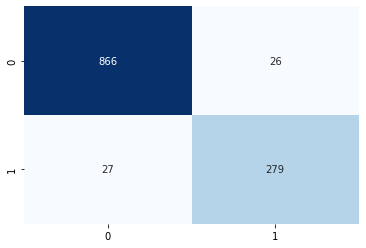

In [ ]:
best_model = gs.best_estimator_
y1_pred = best_model.predict(X1_test)

print(classification_report(y1_test, y1_pred))

sns.heatmap(confusion_matrix(y1_test, y1_pred), annot=True, fmt='d', cmap="Blues", cbar=False);

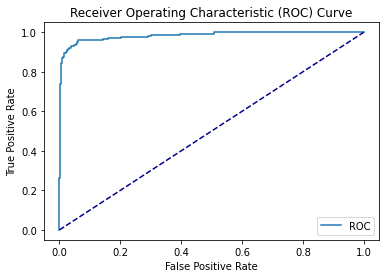

AUC: 0.98


In [ ]:
adaboost = best_model

adaboost.fit(X1_train,y1_train)

y1_probs = adaboost.predict_proba(X1_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

fpr, tpr, thresholds=metrics.roc_curve(y1_test,  y1_probs[:,1])

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y1_test, y1_probs[:,1])
print('AUC: %.2f' % auc)

# 3.13 Random forest for balanced data
The last classifier we try on our dataset is the random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

classifier= RandomForestClassifier()
parameters = {'n_estimators' : [50, 100, 200],
    'criterion' : ['entropy', 'gini'],
             'max_depth' : [1,2,3,4], 
             'min_samples_split' : [4,5,10],
              'min_samples_leaf' : [4,5,10]
             }

gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=10, n_jobs=-1, refit=True)

gs.fit(X_train,y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [1, 2, 3, 4],
                         'min_samples_leaf': [4, 5, 10],
                         'min_samples_split': [4, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='f1', verbose=10)

In [ ]:
#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

***GRIDSEARCH RESULTS***
Best score: 0.763309 using {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
0.742981 (0.009143) with: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 50}
0.733345 (0.000850) with: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 100}
0.741050 (0.009940) with: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 200}
0.735688 (0.007834) with: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50}
0.734661 (0.014492) with: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
0.742506 (0.011405) with: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
0.738824 (0.013618) with: {'crite

              precision    recall  f1-score   support

           0       0.83      0.59      0.69       598
           1       0.68      0.88      0.77       600

    accuracy                           0.73      1198
   macro avg       0.75      0.73      0.73      1198
weighted avg       0.75      0.73      0.73      1198



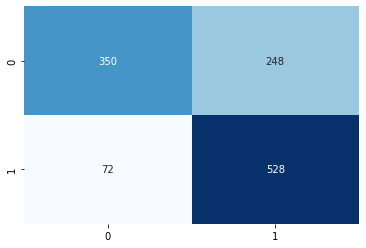

In [ ]:
#TEST ON YOUR TEST SET 
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
 
#Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues", cbar=False);

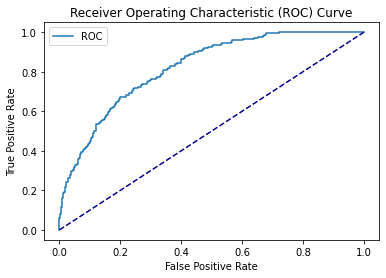

AUC: 0.82


In [ ]:
y_probs = best_model.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

fpr, tpr, thresholds=metrics.roc_curve(y_test,  y_probs[:,1])

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print('AUC: %.2f' % auc)

<AxesSubplot:>

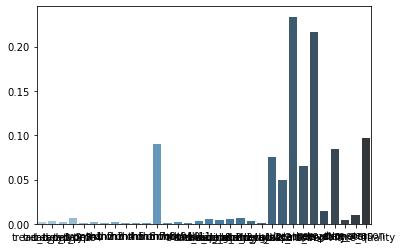

In [ ]:
#We want to see which attributes are the most important with the random forest classifier
sns.barplot(x=X_train.columns, y=best_model.feature_importances_, palette="Blues_d")

# 3.14 Random forest for imbalanced data

*   Lijstitem
*   Lijstitem



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

classifier= RandomForestClassifier()
parameters = {'n_estimators' : [50, 100, 200],
    'criterion' : ['entropy', 'gini'],
             'max_depth' : [1,2,3,4], 
             'min_samples_split' : [4,5,10],
              'min_samples_leaf' : [4,5,10]
             }

gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=10, n_jobs=-1, refit=True)

gs.fit(X1_train,y1_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [1, 2, 3, 4],
                         'min_samples_leaf': [4, 5, 10],
                         'min_samples_split': [4, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='f1', verbose=10)

In [ ]:
#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

***GRIDSEARCH RESULTS***
Best score: 0.875978 using {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 50}
0.620336 (0.039917) with: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 50}
0.676272 (0.020026) with: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 100}
0.654520 (0.052975) with: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 200}
0.650133 (0.059679) with: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50}
0.677052 (0.031650) with: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
0.679006 (0.040717) with: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
0.636178 (0.039318) with: {'crit

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       892
           1       0.98      0.79      0.87       306

    accuracy                           0.94      1198
   macro avg       0.95      0.89      0.92      1198
weighted avg       0.94      0.94      0.94      1198



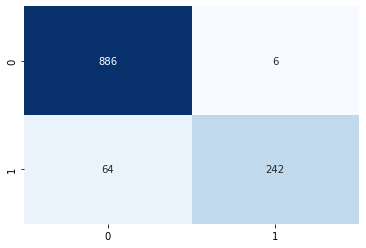

In [ ]:
#TEST ON YOUR TEST SET 
best_model = gs.best_estimator_
y1_pred = best_model.predict(X1_test)

print(classification_report(y1_test, y1_pred))

sns.heatmap(confusion_matrix(y1_test, y1_pred), annot=True, fmt='d', cmap="Blues", cbar=False);

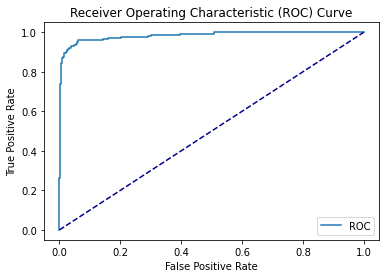

AUC: 0.98


In [ ]:
y_probs = best_model.predict_proba(X1_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

fpr, tpr, thresholds=metrics.roc_curve(y1_test,  y1_probs[:,1])

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y1_test, y1_probs[:,1])
print('AUC: %.2f' % auc)

In [ ]:
#We want to see which attributes are the most important with the random forest classifier
sns.barplot(x=X1_train.columns[best_model.feature_importances_>0], y=best_model.feature_importances_[best_model.feature_importances_>0], palette="Blues_d",rot=90)

NameError: ignored

In [ ]:
def majority_voting(votes):
    """The input is a list of lists, each list contains the predictions of a voter."""
    output = []
    for i in zip(*votes):
        print(i)
        output.append(max(set(i), key = i.count))
    return output

(1, 1, 1, 1)
(1, 1, 1, 1)
(1, 1, 1, 0)
(1, 1, 1, 1)
(1, 0, 0, 0)
(1, 1, 1, 1)


[1, 1, 1, 1, 0, 1]